In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
import copy
from tqdm.notebook import tqdm
from numba import jit
from scipy import stats
import networkx as nx
import re


import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.style.use('seaborn-deep')
plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb,amsmath}'

plt.rcParams["figure.figsize"] = 11.7, 8.3
plt.rcParams["figure.dpi"] = 75

plt.rcParams["font.size"] = 28
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Fira Sans", 'PT Sans', 'Open Sans', 'Roboto', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.fontsize"] = "small"

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"] = 2

plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8

In [4]:
df_nc = pd.read_csv("../results/results_node_classification.csv")

df_nc = df_nc[(df_nc['N_labels'] == 6) & (df_nc['alpha'] == 10)] # the most homophilic graphs

df_nc.head()

,model,with_features,nc_test_size,Beta_s,gamma_s,Ns_obs,kmean_s,gamma_n,kmean_n,gamma_f,N_f,Beta_bi,nu,alpha,N_labels,accuracy
14,GAT_Euclidean,1.0,0.7,1.1,2.1,5000.0,3.0,2.1,3.0,2.1,2000.0,1.1,0.0,10.0,6.0,78.057248
30,GAT_Euclidean,1.0,0.7,1.1,2.1,5000.0,3.0,2.1,3.0,2.1,2000.0,3.0,0.0,10.0,6.0,78.529973
46,GAT_Euclidean,1.0,0.7,1.1,2.1,5000.0,3.0,2.1,3.0,3.5,2000.0,1.1,0.0,10.0,6.0,77.043909
62,GAT_Euclidean,1.0,0.7,1.1,2.1,5000.0,3.0,2.1,3.0,3.5,2000.0,3.0,0.0,10.0,6.0,77.585823
78,GAT_Euclidean,1.0,0.7,1.1,2.1,5000.0,3.0,2.1,30.0,2.1,2000.0,1.1,0.0,10.0,6.0,81.558779


In [10]:
all_params_without_i = ['with_features', 'lp_test_size', 'Beta_s', 'gamma_s', 'Ns_obs', 'kmean_s',
                        'gamma_n', 'kmean_n', 'gamma_f', 'N_f', 'Beta_bi', 'nu']

df_lp = pd.read_csv("../results/results_link_prediction.csv")

# Aggregate over i's
df_lp = df_lp.groupby(['model', *all_params_without_i]).agg({'AUC': 'mean', 'ap': 'mean', 'prc': 'mean'}).reset_index()

df_lp.head()

,model,with_features,lp_test_size,Beta_s,gamma_s,Ns_obs,kmean_s,gamma_n,kmean_n,gamma_f,N_f,Beta_bi,nu,AUC,ap,prc
0,GAT_Euclidean,1.0,0.1,1.1,2.1,5000.0,3.0,2.1,3.0,2.1,2000.0,1.1,0.0,75.706833,73.760052,57.465933
1,GAT_Euclidean,1.0,0.1,1.1,2.1,5000.0,3.0,2.1,3.0,2.1,2000.0,3.0,0.0,76.665890,75.597791,58.274483
2,GAT_Euclidean,1.0,0.1,1.1,2.1,5000.0,3.0,2.1,3.0,3.5,2000.0,1.1,0.0,75.519199,73.277213,57.351168
3,GAT_Euclidean,1.0,0.1,1.1,2.1,5000.0,3.0,2.1,3.0,3.5,2000.0,3.0,0.0,75.382790,73.489528,57.112622
4,GAT_Euclidean,1.0,0.1,1.1,2.1,5000.0,3.0,2.1,30.0,2.1,2000.0,1.1,0.0,82.574855,80.256614,63.757734


In [11]:
def diff_res(df, col, val1, val2, metric):
    a = df[df[col] == val1].groupby('model').agg({metric: 'mean'})
    b = df[df[col] == val2].groupby('model').agg({metric: 'mean'})

    a_std = df[df[col] == val1].groupby('model').agg({metric: 'std'})
    b_std = df[df[col] == val2].groupby('model').agg({metric: 'std'})
    
    c_std = np.sqrt((a_std / b)**2 + (a * b_std / b**2)**2)
    c_std.columns = [f'{metric}_std']  

    return (a_std - b_std).reset_index(), c_std.reset_index()

In [12]:
markers = ['o', 'v', '^', 's', 'X', 'P']
colors = list(sns.color_palette("colorblind"))

def plot_res(res, title):
    sorter = ['MLP_Euclidean', 'HNN_PoincareBall', 'GCN_Euclidean', 'GAT_Euclidean', 'HGCN_PoincareBall']
    res.sort_values(by="model", key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True)
    res.reset_index(drop=True, inplace=True)
    for idx, row in res.iterrows():
        plt.scatter(row['AUC'], row['accuracy'], label=row['model'].split('_')[0], 
                   color=colors[idx], marker=markers[idx], edgecolors='black', s=350, lw=2)

    plt.ylabel(r'$\Delta \,\, \mathrm{std(accuracy)}$')
    plt.xlabel(r'$\Delta \,\, \mathrm{std(AUC)}$')
    plt.axvline(0, color='black', linestyle='--')
    plt.axhline(0, color='black', linestyle='--')
    plt.title(title)

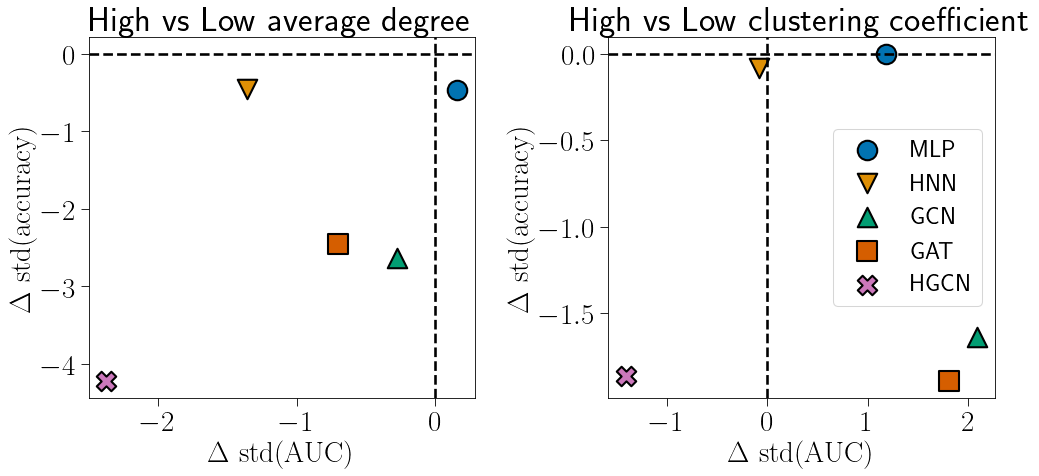

In [13]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
x, x_std = diff_res(df_lp, 'kmean_s', 30.0, 3.0, 'AUC')
y, y_std = diff_res(df_nc, 'kmean_s', 30.0, 3.0, 'accuracy')
res = x.merge(y).merge(x_std).merge(y_std)

plot_res(res, 'High vs Low average degree')


plt.subplot(1, 2, 2)
x, x_std = diff_res(df_lp, 'Beta_s', 3.0, 1.1, 'AUC')
y, y_std = diff_res(df_nc, 'Beta_s', 3.0, 1.1, 'accuracy')
res = x.merge(y).merge(x_std).merge(y_std)

plot_res(res, 'High vs Low clustering coefficient')
plt.legend()

plt.tight_layout()


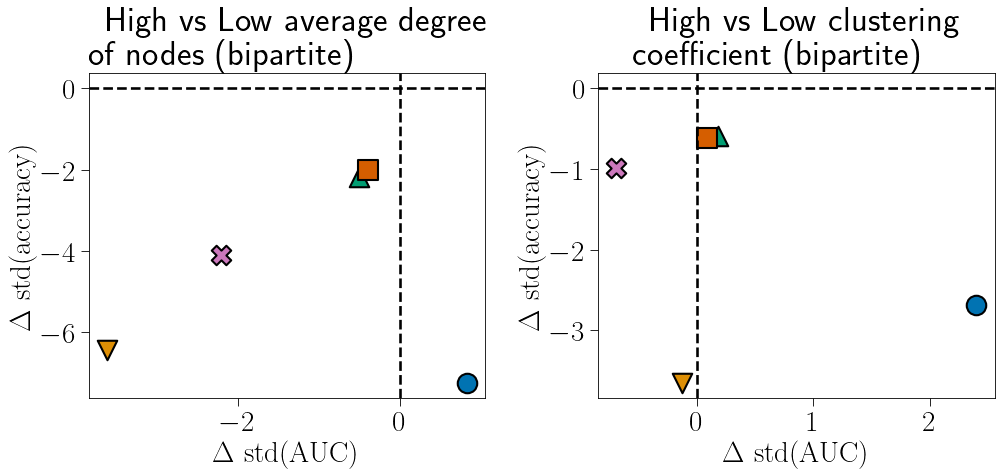

In [14]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
x, x_std = diff_res(df_lp, 'kmean_n', 30.0, 3.0, 'AUC')
y, y_std = diff_res(df_nc, 'kmean_n', 30.0, 3.0, 'accuracy')
res = x.merge(y).merge(x_std).merge(y_std)

plot_res(res, r'High vs Low average degree$\\$of nodes (bipartite)')


plt.subplot(1, 2, 2)
x, x_std = diff_res(df_lp, 'Beta_bi', 3.0, 1.1, 'AUC')
y, y_std = diff_res(df_nc, 'Beta_bi', 3.0, 1.1, 'accuracy')
res = x.merge(y).merge(x_std).merge(y_std)
plot_res(res, r'High vs Low clustering$\\$coefficient (bipartite)')

plt.tight_layout()


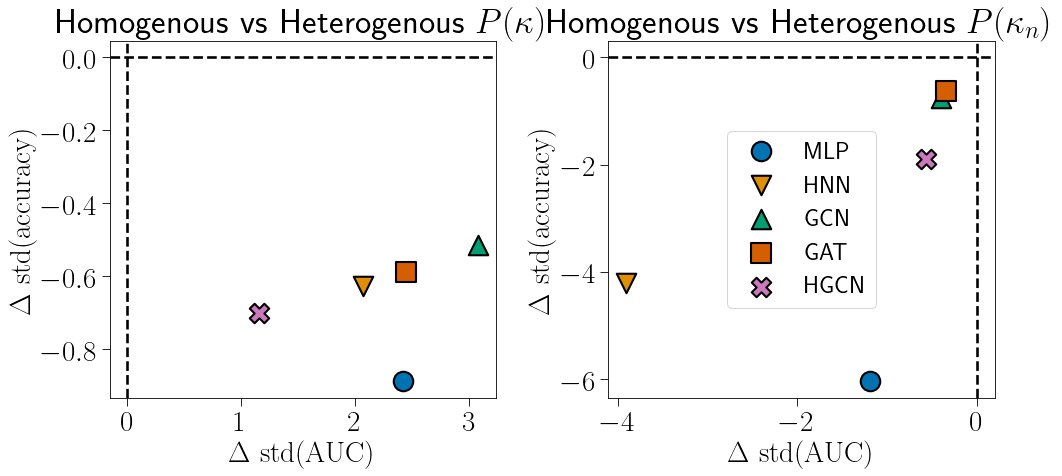

In [15]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
x, x_std = diff_res(df_lp, 'gamma_s', 3.5, 2.1, 'AUC')
y, y_std = diff_res(df_nc, 'gamma_s', 3.5, 2.1, 'accuracy')
res = x.merge(y).merge(x_std).merge(y_std)
plot_res(res, r'Homogenous vs Heterogenous $P(\kappa)$')


plt.subplot(1, 2, 2)
x, x_std = diff_res(df_lp, 'gamma_n', 3.5, 2.1, 'AUC')
y, y_std = diff_res(df_nc, 'gamma_n', 3.5, 2.1, 'accuracy')
res = x.merge(y).merge(x_std).merge(y_std)
plot_res(res, r'Homogenous vs Heterogenous $P(\kappa_n)$')
plt.legend()
plt.tight_layout()


---
---

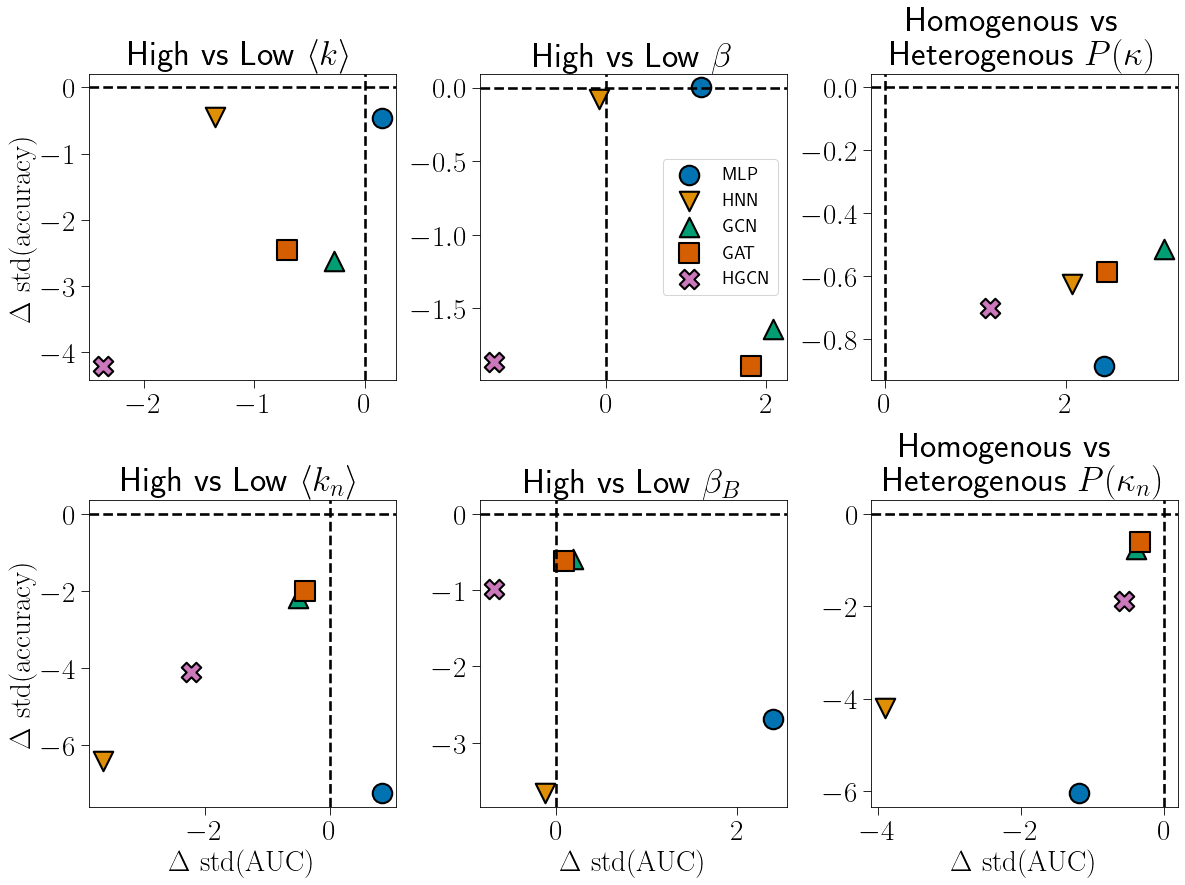

In [16]:
plt.figure(figsize=(16, 12))

# Unipartite network
plt.subplot(2, 3, 1)
x, x_std = diff_res(df_lp, 'kmean_s', 30, 3, 'AUC')
y, y_std = diff_res(df_nc, 'kmean_s', 30, 3, 'accuracy')
res = x.merge(y).merge(x_std).merge(y_std)
plot_res(res, r'High vs Low $\left<k\right>$')
plt.xlabel('')

plt.subplot(2, 3, 2)
x, x_std = diff_res(df_lp, 'Beta_s', 3.0, 1.1, 'AUC')
y, y_std = diff_res(df_nc, 'Beta_s', 3.0, 1.1, 'accuracy')
res = x.merge(y).merge(x_std).merge(y_std)
plot_res(res, r'High vs Low $\beta$')
plt.legend(fontsize=18)

plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 3, 3)
x, x_std = diff_res(df_lp, 'gamma_s', 3.5, 2.1, 'AUC')
y, y_std = diff_res(df_nc, 'gamma_s', 3.5, 2.1, 'accuracy')
res = x.merge(y).merge(x_std).merge(y_std)
plot_res(res, r'Homogenous vs \\ Heterogenous $P(\kappa)$')
plt.xlabel('')
plt.ylabel('')


# Bipartite network
plt.subplot(2, 3, 4)
x, x_std = diff_res(df_lp, 'kmean_n', 30, 3, 'AUC')
y, y_std = diff_res(df_nc, 'kmean_n', 30, 3, 'accuracy')
res = x.merge(y).merge(x_std).merge(y_std)
plot_res(res, r'High vs Low $\left<k_n\right>$')

plt.subplot(2, 3, 5)
x, x_std = diff_res(df_lp, 'Beta_bi', 3.0, 1.1, 'AUC')
y, y_std = diff_res(df_nc, 'Beta_bi', 3.0, 1.1, 'accuracy')
res = x.merge(y).merge(x_std).merge(y_std)
plot_res(res, r'High vs Low $\beta_B$')
plt.ylabel('')

plt.subplot(2, 3, 6)
x, x_std = diff_res(df_lp, 'gamma_n', 3.5, 2.1, 'AUC')
y, y_std = diff_res(df_nc, 'gamma_n', 3.5, 2.1, 'accuracy')
res = x.merge(y).merge(x_std).merge(y_std)
plot_res(res, r'Homogenous vs \\ Heterogenous $P(\kappa_n)$')
plt.ylabel('')

plt.tight_layout(pad=0.5)